In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pd.read_csv('../data/jan_data.csv')
df['time'] = pd.to_datetime(df['time'])

df.iloc[1800]['dollar_open_interest_close']

df.tail(10)[['time','premium']]


C:\Users\vosko\AppData\Local\Temp\ipykernel_25580\43016817.py:5: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/jan_data.csv')


,time,premium
51366,2024-01-26 19:41:00,-0.876957
51367,2024-01-26 19:39:00,-0.834710
51368,2024-01-26 19:40:00,-0.795773
51369,2024-01-26 19:41:00,-0.876957
51370,2024-01-26 19:42:00,-0.840492
51371,2024-01-26 19:40:00,-0.795773
51372,2024-01-26 19:41:00,-0.876957
51373,2024-01-26 19:42:00,-0.840492
51374,2024-01-26 19:43:00,-0.834614
51375,2024-01-26 19:44:00,-0.937724


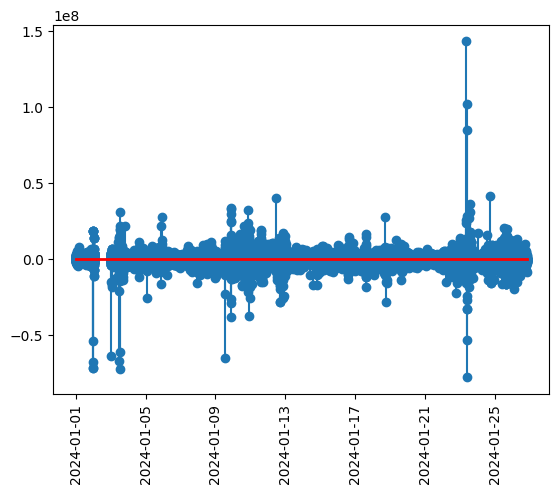

,Unnamed: 0,time,product,high_price,coin_open_interest_close,funding_rate,sell_coin_volume,search_resolution,search_end_time,liquidations_dollar_volume,...,coin_volume,close_price,buy_liquidations_coin_volume,exchange,sell_liquidations_coin_volume,buy_liquidations_dollar_volume,coin,sell_trades,search_params,diff
1707,1707,2024-01-03,ETHUSDT,2358.21,790111.609,0.000285,338.017,1.0,2024-01-04T00:00:00+00:00,0.0,...,1258.83,2358.21,0.0,binance-futures,0.0,0.0,ETH,496,NaN,-6.406379e+07
1749,1749,2024-01-03,ETHUSDT,2358.21,790111.609,0.000285,338.017,1.0,2024-01-03T00:01:00+00:00,0.0,...,1258.83,2358.21,0.0,binance-futures,0.0,0.0,ETH,496,NaN,-5.286299e+05


In [93]:

df['diff'] = df['dollar_open_interest_close'].diff()
df_jan2324 = df.loc[(df['time']>'2024-01-24')]
df_jan2324 = df
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()


In [90]:
from scipy import stats
import math

df_slice = df_jan2324.loc[df_jan2324['search_resolution']==1]
df_slice = df_slice.sort_values(by='time')
df_slice = df_slice.drop_duplicates(subset=['time'])

window_size = 120
step = 60
start = 0
end = start + window_size
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    if tau.statistic < 0:
        if max_decrease_tau['tau'] > tau.statistic:
            max_decrease_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut.iloc[-1]['dollar_open_interest_close']-df_cut.iloc[1]['dollar_open_interest_close']
        print(f"{oi_increase:,f} USD, {tau.statistic}, 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice.iloc[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice.iloc[max_increase_tau['range_high']]['time']}")
        max_increase_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    # print(f"Range: {start} to {end}: {stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])}")
    start += step
    end += step

print(f"Max increase Tau: {max_increase_tau}, date_start: {df_slice.iloc[max_increase_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_increase_tau['range_high']]['time']}")
print(f"Max decrease Tau: {max_decrease_tau}, date_start: {df_slice.iloc[max_decrease_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_decrease_tau['range_high']]['time']}")

# spot perp basis, funding


32,984,049.713000 USD, 0.810924369747899, 'Avg funding:' 0.00029034566666666665, 'Avg premium:' 1.9459997197691665, 'date_start': 2024-01-01 00:00:00, 'date_end': 2024-01-01 00:00:00
9,506,231.059000 USD, 0.04313725490196078, 'Avg funding:' 0.00030816416666666673, 'Avg premium:' 1.9854695067233334, 'date_start': 2024-01-01 00:00:00, 'date_end': 2024-01-01 02:00:00
14,497,305.499000 USD, 0.538375350140056, 'Avg funding:' 0.00032085441666666675, 'Avg premium:' 1.7012363280908331, 'date_start': 2024-01-01 01:00:00, 'date_end': 2024-01-01 03:00:00
12,016,868.379000 USD, 0.49299719887955173, 'Avg funding:' 0.00032019858333333324, 'Avg premium:' 1.7630191985208332, 'date_start': 2024-01-01 04:00:00, 'date_end': 2024-01-01 06:00:00
13,581,974.245000 USD, 0.5386554621848739, 'Avg funding:' 0.0003201265, 'Avg premium:' 1.7727874869650002, 'date_start': 2024-01-01 05:00:00, 'date_end': 2024-01-01 07:00:00
1,956,077.383000 USD, 0.11204481792717086, 'Avg funding:' 0.0003162954166666667, 'Avg premi